In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gc

In [ ]:
# Загрузка и предобработка данных
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews", )
colnames = ['ton','review1', 'review2']
amazon_train = pd.read_csv("/kaggle/input/amazon-reviews/train.csv", names=colnames, header=None)

# Заполнение пропусков и объединение отзывов
amazon_train['review1'] = amazon_train['review1'].fillna(' ')
amazon_train['review'] = amazon_train['review1'] + ' ' + amazon_train['review2']
amazon_train.drop(['review1', 'review2'], axis=1, inplace=True)

# Преобразование меток: 1 -> -1 (негативные), 2 -> 1 (позитивные)
amazon_train['ton'] = amazon_train['ton'].apply(lambda x: -1 if x == 1 else 1)

# Освобождение памяти
words = amazon_train['review'].values
y = amazon_train['ton'].values
del amazon_train
gc.collect()

X_train = words
y_train = y

# Освобождение памяти
del words, y
gc.collect()

0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TfidfVectorizer
vectorizer = TfidfVectorizer(
  ngram_range=(1, 1),
  stop_words='english',
  dtype=np.float32,
  max_features=2**14
)

vectorizer.fit(X_train)

TfidfVectorizer(dtype=<class 'numpy.float32'>, max_features=16384,
                stop_words='english')

In [ ]:
# Сохранение векторайзера
from pickle import dump


with open("amazonVectorizer_1.1.pkl", "wb") as f:
  dump(vectorizer, f, protocol = 5)

In [ ]:
# Загрузка векторайзера
from pickle import load


with open("amazonVectorizer_1.1.pkl", "rb") as f:
  vectorizer = load(f)

In [ ]:
from sklearn.linear_model import SGDClassifier

# Инициализация модели
model = SGDClassifier(
  loss='log_loss',
  penalty='l2',
  learning_rate='optimal',
  random_state=42,
  alpha=0.00005,
  eta0=0.01
)

In [ ]:
# Обучение модели по батчам
batch_size = 1000
n_batches = int(np.ceil(len(X_train) / batch_size))

# Основное обучение
for i in range(n_batches):
  start_idx = i * batch_size
  end_idx = min((i + 1) * batch_size, len(X_train))

  # vectorizer.partial_fit(X_train[start_idx:end_idx]) # HashingVectorizer does not need partial_fit
  X_batch = vectorizer.transform(X_train[start_idx:end_idx])

  model.partial_fit(X_batch, y_train[start_idx:end_idx], classes=np.array([-1, 1]))

  del X_batch
  if i % 50 == 0 or i == n_batches - 1:
    gc.collect()
    print(f"Обработано тренировочных батчей: {i+1}/{n_batches}")


Обработано тренировочных батчей: 1/3600
Обработано тренировочных батчей: 51/3600
Обработано тренировочных батчей: 101/3600
Обработано тренировочных батчей: 151/3600
Обработано тренировочных батчей: 201/3600
Обработано тренировочных батчей: 251/3600
Обработано тренировочных батчей: 301/3600
Обработано тренировочных батчей: 351/3600
Обработано тренировочных батчей: 401/3600
Обработано тренировочных батчей: 451/3600
Обработано тренировочных батчей: 501/3600
Обработано тренировочных батчей: 551/3600
Обработано тренировочных батчей: 601/3600
Обработано тренировочных батчей: 651/3600
Обработано тренировочных батчей: 701/3600
Обработано тренировочных батчей: 751/3600
Обработано тренировочных батчей: 801/3600
Обработано тренировочных батчей: 851/3600
Обработано тренировочных батчей: 901/3600
Обработано тренировочных батчей: 951/3600
Обработано тренировочных батчей: 1001/3600
Обработано тренировочных батчей: 1051/3600
Обработано тренировочных батчей: 1101/3600
Обработано тренировочных батчей: 1

In [ ]:
# Загрузка тестовых данных
test_df = pd.read_csv("/kaggle/input/amazon-reviews/test.csv", names=colnames, header=None)

# Обработка тестовых данных
test_df['review1'] = test_df['review1'].fillna(' ')
test_df['review'] = test_df['review1'] + ' ' + test_df['review2']
test_df.drop(['review1', 'review2'], axis=1, inplace=True)
test_df['ton'] = test_df['ton'].apply(lambda x: -1 if x == 1 else 1)

# Подготовка тестовых данных
X_test = test_df['review'].values
y_test = test_df['ton'].values

del test_df
gc.collect()

12

In [ ]:
# Тестирование модели на тестовых данных
test_batch_size = 2000
test_batches = int(np.ceil(len(X_test) / test_batch_size))
all_confidence = []  # confidence scores
all_predicted_labels = []  # Метки, полученные из confidence
all_true_labels = []

for i in range(test_batches):
  start_idx = i * test_batch_size
  end_idx = min((i + 1) * test_batch_size, len(X_test))

  # Векторизация
  X_test_batch = vectorizer.transform(X_test[start_idx:end_idx])

  # Предсказание вероятностей
  probas = model.predict_proba(X_test_batch)
  batch_confidence = 2 * probas[:, 1] - 1
  batch_pred_labels = np.where(batch_confidence >= 0, 1, -1)

  all_confidence.extend(batch_confidence)
  all_predicted_labels.extend(batch_pred_labels)
  all_true_labels.extend(y_test[start_idx:end_idx])

  del X_test_batch, probas
  if i % 20 == 0 or i == test_batches - 1:
    gc.collect()
    print(f"Обработано тестовых батчей: {i+1}/{test_batches}")

# Оценка точности
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"\nТочность на тестовых данных: {accuracy:.4f}")
print(f"Доля правильных ответов: {accuracy * 100:.2f}%")

Обработано тестовых батчей: 1/200
Обработано тестовых батчей: 21/200
Обработано тестовых батчей: 41/200
Обработано тестовых батчей: 61/200
Обработано тестовых батчей: 81/200
Обработано тестовых батчей: 101/200
Обработано тестовых батчей: 121/200
Обработано тестовых батчей: 141/200
Обработано тестовых батчей: 161/200
Обработано тестовых батчей: 181/200
Обработано тестовых батчей: 200/200

Точность на тестовых данных: 0.8767
Доля правильных ответов: 87.67%


In [ ]:
# Примеры предсказаний
sample_reviews = [
  "This thing is absolutely wonderful! I love it!",
  "Terrible quality, would not recommend",
  "It's normal"
]

sample_vectors = vectorizer.transform(sample_reviews)
sample_probas = model.predict_proba(sample_vectors)
sample_confidence = 2 * sample_probas[:, 1] - 1

print("\nПримеры предсказаний:")
for text, conf in zip(sample_reviews, sample_confidence):
  # Форматируем вывод confidence score
  sentiment = "Позитивный" if conf >= 0 else "Негативный"
  print(f"Отзыв: {text[:60]} -> Confidence: {conf:.4f} ({sentiment})")


Примеры предсказаний:
Отзыв: This thing is absolutely wonderful! I love it! -> Confidence: 0.9762 (Позитивный)
Отзыв: Terrible quality, would not recommend -> Confidence: -0.8978 (Негативный)
Отзыв: It's normal -> Confidence: -0.2052 (Негативный)


In [ ]:
# Сохранение модели
from pickle import dump


with open("amazonSGD_1.1.pkl", "wb") as f:
  dump(model, f, protocol=5)

In [ ]:
# Загрузка модели
from pickle import load


with open("amazonSGD_1.1.pkl", "rb") as f:
  model = load(f)

In [ ]:
model.densify()
weights = model.coef_.tolist()[0]
features = vectorizer.get_feature_names_out()
weighted_features = list(zip(features, weights))
weighted_features_sorted = sorted(weighted_features, key=lambda x: x[1])

weighted_features_sorted[-10:]

Text(0.5, 1.0, '10 слов с наибольшим отрицательным вкладом в тональность')

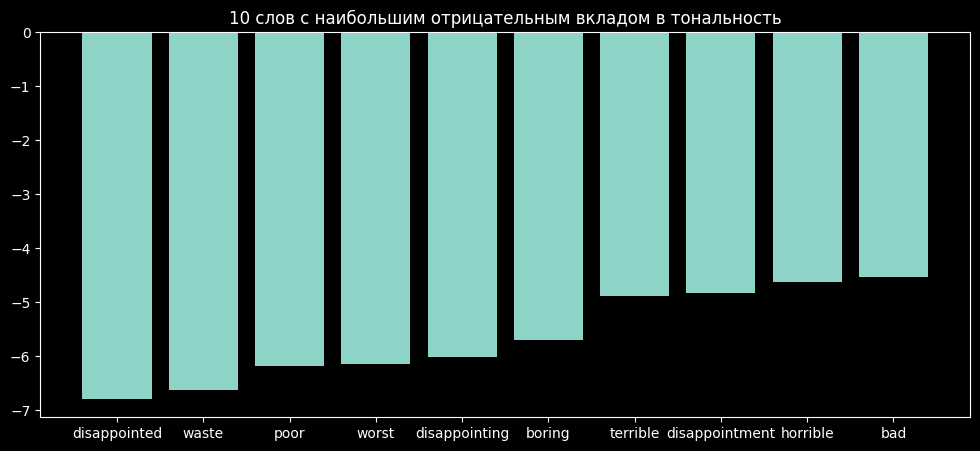

In [ ]:
from matplotlib import pyplot as plt


plt.style.use('dark_background')

top_features = [feature for feature, _ in weighted_features_sorted[0:10]]
top_weights = [weight for _, weight in weighted_features_sorted[0:10]]

plt.figure(figsize=(12, 5))
plt.bar(top_features, top_weights)
plt.title("10 слов с наибольшим отрицательным вкладом в тональность")

Text(0.5, 1.0, '10 слов с наибольшим положительным вкладом в тональность')

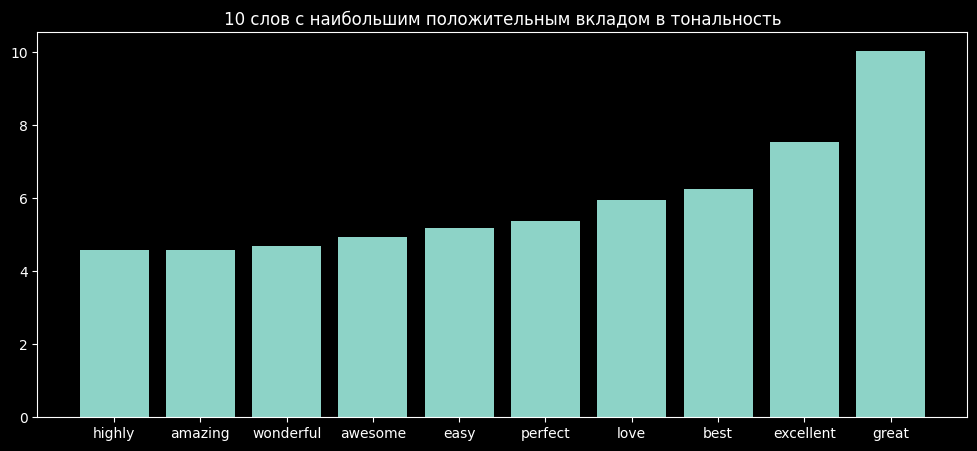

In [ ]:
top_features = [feature for feature, _ in weighted_features_sorted[-10:]]
top_weights = [weight for _, weight in weighted_features_sorted[-10:]]

plt.figure(figsize=(12, 5))
plt.bar(top_features, top_weights)
plt.title("10 слов с наибольшим положительным вкладом в тональность")

In [ ]:
weighted_features_sorted[:100]

[('disappointed', -6.791813373565674),
 ('waste', -6.623457908630371),
 ('poor', -6.184829235076904),
 ('worst', -6.138386249542236),
 ('disappointing', -6.009249210357666),
 ('boring', -5.700222969055176),
 ('terrible', -4.876311779022217),
 ('disappointment', -4.823975086212158),
 ('horrible', -4.621542453765869),
 ('bad', -4.534101486206055),
 ('money', -4.480135440826416),
 ('poorly', -4.07481050491333),
 ('awful', -3.927056074142456),
 ('unfortunately', -3.8413028717041016),
 ('useless', -3.6868042945861816),
 ('return', -3.550658702850342),
 ('returned', -3.527902603149414),
 ('instead', -3.3190743923187256),
 ('broke', -3.2367985248565674),
 ('junk', -3.2103450298309326),
 ('didn', -3.147197961807251),
 ('don', -3.122840166091919),
 ('doesn', -3.043396234512329),
 ('sorry', -3.0364840030670166),
 ('did', -2.9716150760650635),
 ('worse', -2.9693398475646973),
 ('garbage', -2.9047467708587646),
 ('unless', -2.8869071006774902),
 ('ok', -2.8486430644989014),
 ('beware', -2.83863687

In [ ]:
weighted_features_sorted[-100:]

[('truly', 1.2592860460281372),
 ('holds', 1.2613927125930786),
 ('wonderfully', 1.2736129760742188),
 ('greatest', 1.2792072296142578),
 ('masterpiece', 1.2884103059768677),
 ('quick', 1.295965552330017),
 ('pleasantly', 1.303205966949463),
 ('makes', 1.3168796300888062),
 ('recommend', 1.323554515838623),
 ('provoking', 1.3378785848617554),
 ('wow', 1.3406509160995483),
 ('gem', 1.3531829118728638),
 ('stores', 1.3580527305603027),
 ('awsome', 1.3650131225585938),
 ('lives', 1.3849400281906128),
 ('easier', 1.413558006286621),
 ('ve', 1.4137599468231201),
 ('nicely', 1.420591115951538),
 ('gift', 1.4555978775024414),
 ('recommended', 1.4810566902160645),
 ('hooked', 1.4950251579284668),
 ('refreshing', 1.5211023092269897),
 ('especially', 1.5217797756195068),
 ('simple', 1.5341206789016724),
 ('fabulous', 1.544715404510498),
 ('collection', 1.5461533069610596),
 ('fast', 1.5463260412216187),
 ('brings', 1.5568104982376099),
 ('entertaining', 1.5764442682266235),
 ('little', 1.5935245

In [ ]:
from wordcloud import WordCloud


path = kagglehub.dataset_download("kritanjalijain/amazon-reviews", )
colnames = ['ton','review1', 'review2']
amazon_train = pd.read_csv("/kaggle/input/amazon-reviews/train.csv", names=colnames, header=None)

# Заполнение пропусков и объединение отзывов
amazon_train['review1'] = amazon_train['review1'].fillna(' ')
amazon_train['review'] = amazon_train['review1'] + ' ' + amazon_train['review2']
amazon_train.drop(['review1', 'review2'], axis=1, inplace=True)

positive_words = amazon_train.loc[amazon_train['ton'] == 2]['review'].values
negative_words = amazon_train.loc[amazon_train['ton'] == 1]['review'].values

del amazon_train
gc.collect()

4722

In [ ]:
import matplotlib.pyplot as plt

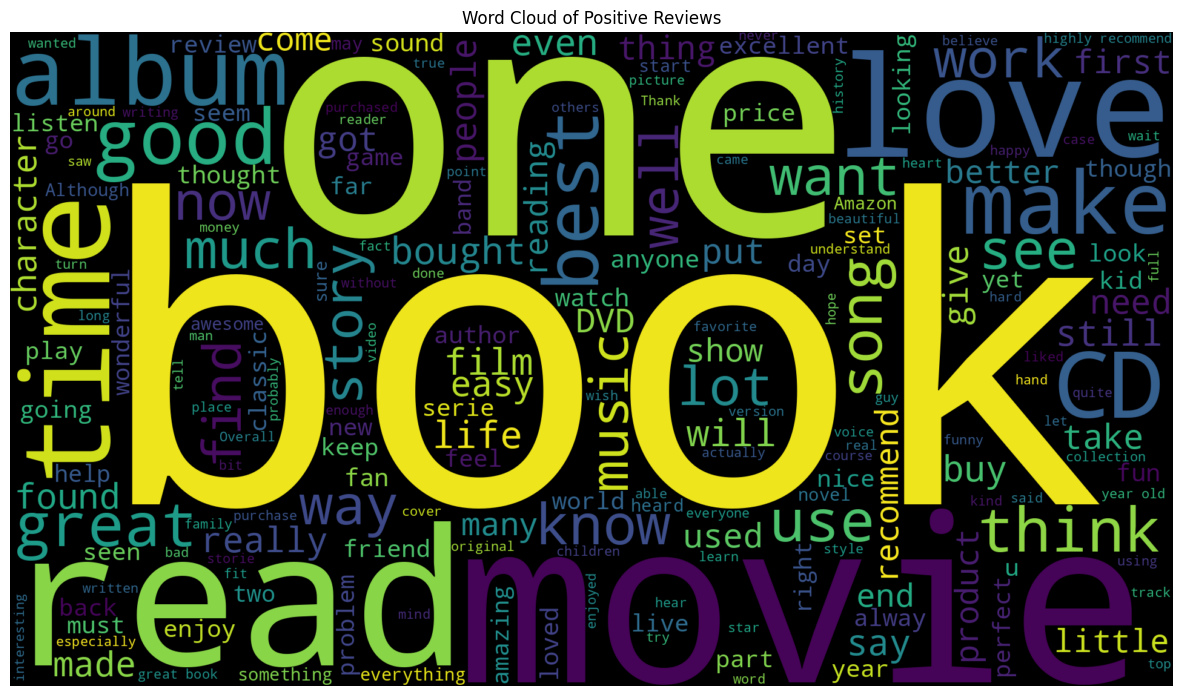

In [ ]:
positive_reviews_text = " ".join(positive_words[:len(positive_words) // 4])

wordcloud_positive = WordCloud(width=1920, height=1080).generate(positive_reviews_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Reviews")
plt.show()

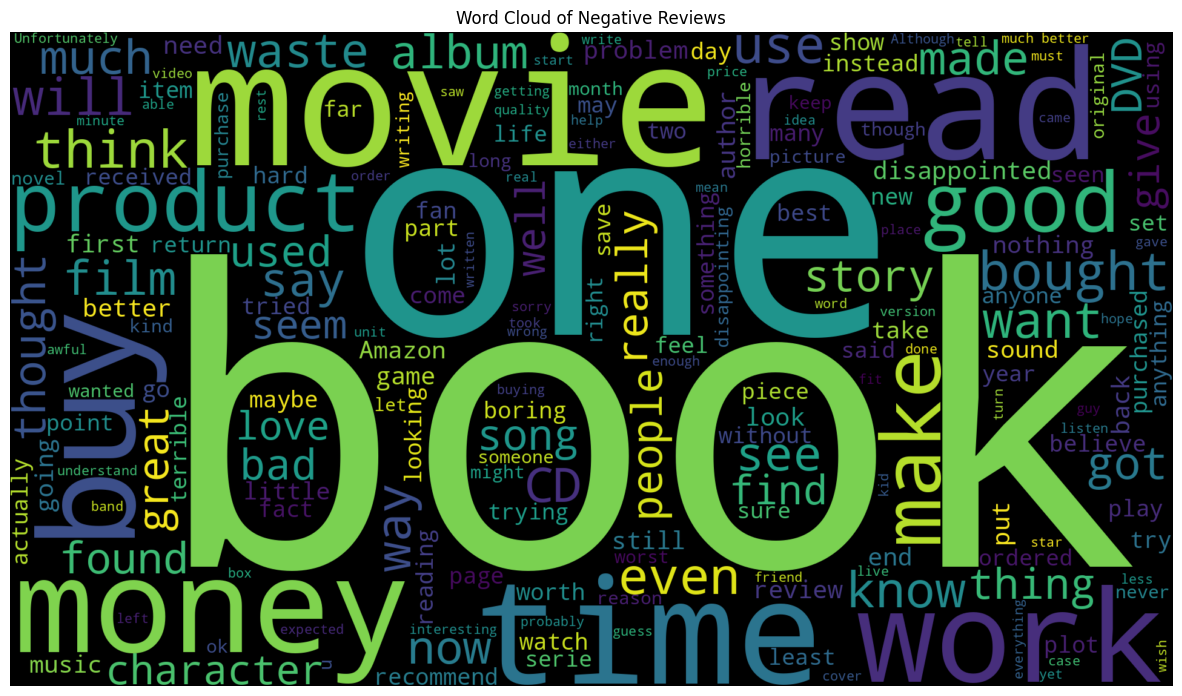

In [ ]:
negative_reviews_text = " ".join(negative_words[:len(negative_words) // 4])

wordcloud_negative = WordCloud(width=1920, height=1080).generate(negative_reviews_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show()